In [1]:
# Getting data from git repo
!git clone https://github.com/SiddheshKanawade/face_detection.git
%cd face_detection

Cloning into 'face_detection'...
remote: Enumerating objects: 897, done.
remote: Counting objects: 100% (897/897), done.
remote: Compressing objects: 100% (892/892), done.
remote: Total 897 (delta 3), reused 890 (delta 2), pack-reused 0
Receiving objects: 100% (897/897), 6.17 MiB | 30.83 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/face_detection


In [170]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os

In [171]:
"""
Remove the README file from Dataset_pgl
"""
Faces_Dataset = "/content/face_detection/Dataset_pgl"
Images = []

for file in os.listdir(Faces_Dataset):
  if(file=='README'):
    continue
  ind_path = f"{Faces_Dataset}/{file}"
  for image in os.listdir(ind_path):
    Images.append(ind_path + "/" + image)
    filename, extension  = os.path.splitext(f"{ind_path}/{image}")
    if extension == ".pgm":
      new_file = "{}.png".format(filename)
      with PIL.Image.open(f"{ind_path}/{image}") as im:
        im.save(new_file)
      os.remove(f"{ind_path}/{image}")

In [172]:
"""
Rerun the above cell twice if getting .png not found error. This is maybe because the google colab takes some time to load the updated filestructure
"""

SUB = 40        # Number of distinct faces
IPS = 10        # Images per face
W = 92          # Width
H = 112         # Height
total_images = SUB * IPS;

face_mat = np.zeros((total_images,W*H),dtype=np.float64)   # To store images
count = 0;
fig = plt.figure(figsize=(150,300))
for image in Images:
  img = plt.imread(image)
  face_mat[count,:] = np.array(img, dtype='float64').flatten()
  if(count<100):
    fig.add_subplot(20,5,count+1)
    plt.imshow(img,cmap = 'gray')
  count += 1;
    

In [173]:
# store the ids corresponding to images
train_map = {}
test_map = {}

In [174]:
# Split the dataset into train and test based on given train images per subjects parameter
def train_test_split(face_mat,Train_per_sub = 8):
    Train_images = Train_per_sub * SUB          # Total Train Images
    Test_per_sub = IPS - Train_per_sub      # Test Images per face
    Test_images = Test_per_sub*SUB             # Total Test Ims
   
    train_mat = np.zeros((Train_images,W*H))   # Train Matrix
    test_mat = np.zeros((Test_images,W*H))     # Test Matrix
    train_count = 0                         # Train counter
    test_count = 0                          # Test counter

    p_uid = -1
    for count,face in enumerate(face_mat):
      if count%IPS == 0:
        p_uid += 1;
      if count%IPS <Test_per_sub:
        test_mat[test_count] = face_mat[count]
        test_map[test_count] = p_uid
        test_count += 1
      else:
        train_mat[train_count] = face_mat[count]
        train_map[train_count] = p_uid
        train_count += 1
    return train_mat,test_mat

def show_im(image):
  plt.imshow(image,cmap='gray')
  plt.show()

Shape of A is (10304, 280)
Shape of A_avg is (10304,)
This is the average face-


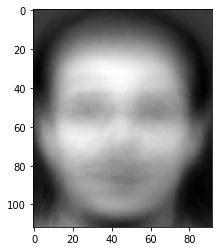

Phi shape is (10304, 280)


In [175]:
train_per_sub = 7                           # Train images per face
train_images = train_per_sub * SUB          # Total train images
face_mat /= 255                             # Normalised the matrix. We can have maximum 255 as pixel intensity. Pixel intensity varies from 0 to 255

# Train Test split
train_mat, test_mat = train_test_split(face_mat,train_per_sub)

# We need A of shape (W*H,Train_images), hence do transpose
A = train_mat.T
print(f"Shape of A is {A.shape}")

# Calculating Average Face
A_avg = np.mean(A,axis=1)
print(f"Shape of A_avg is {A_avg.shape}")
print("This is the average face-")
show_im(np.reshape(A_avg,(H,W)))

# Calculating Normalized Faces
Phi = np.subtract(A.T ,A_avg.T).T
print(f"Phi shape is {Phi.shape}")

Cov_Train_images*Train_images shape is  (280, 280)
These are the 20 most important eigen values - 


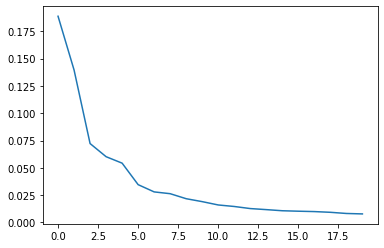

We choose 91 principal components to capture 0.9 variance out of above Cov


In [176]:
# Calculating covarience matrices and their eigen values
Cov = np.dot(Phi.T,Phi)
print("Cov_Train_images*Train_images shape is ",Cov.shape)

# Finding the Eigen vectors of the Covariance Matrix
eig,eig_vec = np.linalg.eig(Cov)
eig,eig_vec = np.real(eig),np.real(eig_vec)
print("These are the 20 most important eigen values - ")

plt.plot(eig[:20])
plt.show()

# Choosing number of principal components
variance = 0.90
for k in range(len(eig)):
  if np.sum(eig[:k])/np.sum(eig) > variance:
    print("We choose {} principal components to capture {} variance out of above Cov".format(k,variance))
    break

These are the top 10 eigen faces


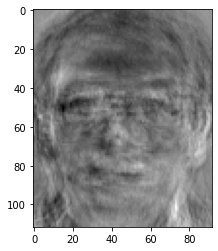

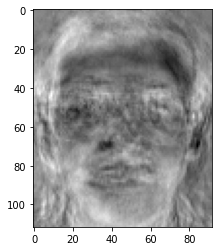

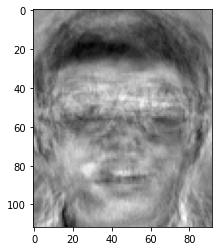

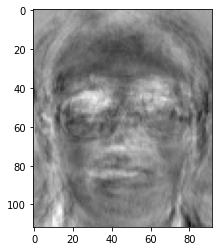

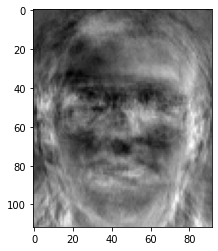

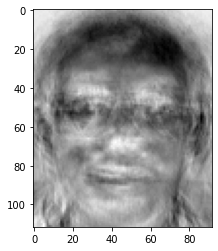

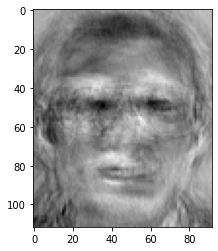

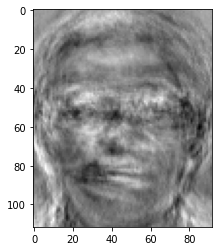

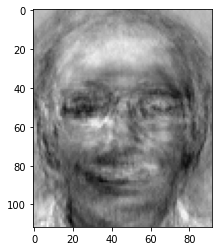

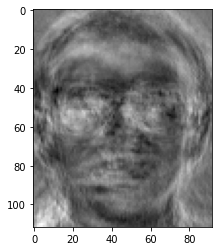

In [177]:
eig_pairs = [(eig[index], eig_vec[:,index]) for index in range(len(eig))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eig_sort  = np.array([eig_pairs[index][0] for index in range(len(eig))])
eig_vec_sort = np.array([eig_pairs[index][1] for index in range(len(eig))])

# Selecting K values out of train_images and dotting W.H*train_images with train_images*k
eig_k,eig_k_vec = eig_sort[:k],np.dot(Phi,eig_vec_sort[:,:k])

print("These are the top 10 eigen faces")
for i in range(10):
  show_im(np.reshape(eig_k_vec.T[i],(H,W)))

In [178]:
# Projecting the Normalized images on to the K vector Space
embedded = np.dot(Phi.T,eig_k_vec)
print("Embeddin for all faces", embedded.shape)

Embeddin for all faces (280, 91)


**FOR TESTING**

In [179]:
B = test_mat.T
print("Shape of B is ",B.shape)

# Calculating Normalized Faces
Phi_test = np.subtract(B.T ,A_avg.T).T
print("Phi test shape is ",Phi_test.shape)

omega = np.dot(Phi_test.T,eig_k_vec)
print("Omega shape is ",omega.shape)

Shape of B is  (10304, 120)
Phi test shape is  (10304, 120)
Omega shape is  (120, 91)


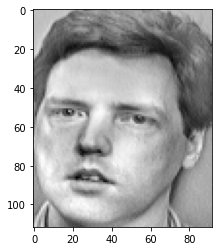

In [180]:
show_im(np.reshape(Phi_test.T[69],(H,W)))

In [181]:
# check faces with the train images
def check_faces(face,known_faces):
    check_mat = np.zeros(test_mat.shape[0])
    for i in range(test_mat.shape[0]):
      min_dist = float("inf")
      for j in range(train_mat.shape[0]):
        dist = np.linalg.norm(face[i]-known_faces[j])
        if(dist < min_dist):
          min_dist = dist
          check_mat[i] = train_map[j]
    return check_mat

# get the correct and incorrect count
def corrects_incorrects(check_mat):
    correct = 0
    incorrect = 0
    for i in range (len(check_mat)):
      if check_mat[i] == test_map[i] :
        correct += 1
      else:
        incorrect += 1
    return correct,incorrect

def accuracy(correct,incorrect):
  acc = correct/(correct+incorrect)
  return acc*100

In [182]:
check_matrix = check_faces(omega,embedded)
correct,incorrect = corrects_incorrects(check_matrix)
acc = accuracy(correct,incorrect)
print("Correctly predicted : ",correct)
print("Incorrectly predicted: " ,incorrect)
print("Accuracy of the model is {} %".format(acc))

Correctly predicted :  114
Incorrectly predicted:  6
Accuracy of the model is 95.0 %


The accuracy above is for the test data splitted from the original data. The accuracy will be lower for a new image.

In [183]:
for i in range(len(check_matrix)):
  if check_matrix[i] == test_map[i] : 
    print("The test image {} is matched with p_id {}".format(str(i),str(test_map[i])))
  else:
    print("The test image {} is matched with p_id {}, however real is with id {}, false detected".format(str(i),str(check_matrix[i]),str(test_map[i])))

The test image 0 is matched with p_id 0
The test image 1 is matched with p_id 0
The test image 2 is matched with p_id 0
The test image 3 is matched with p_id 1
The test image 4 is matched with p_id 1
The test image 5 is matched with p_id 1
The test image 6 is matched with p_id 2
The test image 7 is matched with p_id 2
The test image 8 is matched with p_id 2
The test image 9 is matched with p_id 3
The test image 10 is matched with p_id 3
The test image 11 is matched with p_id 3
The test image 12 is matched with p_id 4
The test image 13 is matched with p_id 4
The test image 14 is matched with p_id 4
The test image 15 is matched with p_id 5
The test image 16 is matched with p_id 5
The test image 17 is matched with p_id 5
The test image 18 is matched with p_id 6
The test image 19 is matched with p_id 6
The test image 20 is matched with p_id 6
The test image 21 is matched with p_id 7
The test image 22 is matched with p_id 7
The test image 23 is matched with p_id 7
The test image 24 is match